In [17]:
#Open the sample file:
import numpy as np
v, f = np.loadtxt('sample.csv', delimiter=',', unpack=True)

#Turn percentages into frequencies:
f = f/100.

#Visualize data sample:
print('**v*     ***f**')
for i in zip(v, f):
    print('{0:4.1f}\t {1:5.4}'.format(*i))
    
#Gamma function:
from scipy.special import gamma

**v*     ***f**
 1.0	 0.046
 2.0	 0.066
 3.0	 0.087
 4.0	 0.105
 5.0	 0.115
 6.0	 0.1045
 7.0	 0.101
 8.0	 0.095
 9.0	 0.079
10.0	 0.066
11.0	 0.058
12.0	 0.0435
13.0	 0.034


In [18]:
%%timeit
#Empirical method:
def empirical(_v, _f):
    mean_v = np.mean(_v)
    std_v = np.std(_v)
    _k = (std_v/mean_v)**(-1.086)
    _c = mean_v/gamma(1. + 1./_k)
    return _k, _c

89.9 ns ± 5.26 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [19]:
%%timeit
#Moment method:
def moment(_v, _f):
    mean_v = np.mean(_v)
    std_v = np.std(_v)
    lht = (mean_v/std_v)**2
    g = 1.
    while True:
        rht = (gamma(1.+1./g)**2)/(gamma(1.+2./g)-gamma(1.+1./g)**2)
        if abs((lht - rht)/lht) < 0.01:
            break
        else:
            g = g + 0.0001
    _c = mean_v/gamma(1. + 1./g)
    return g, _c

90 ns ± 2.38 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [20]:
%%timeit
#Energy pattern factor method:
def energy(_v, _f):
    mean_v = np.mean(_v)
    mean_v3 = np.mean(_v**3)
    epf = mean_v3/(mean_v**3)
    _k = 1. + 3.69/epf**2
    _c = mean_v/gamma(1. + 1./_k)
    return _k, _c

86.5 ns ± 1.63 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [21]:
%%timeit
#MAXIMUM LIKELIHOOD METHOD
def mlm(_v, _f):
    g = 1.
    while True:
        t1 = np.sum((_v**g)*np.log(_v))
        t2 = np.sum(_v**g)
        t3 = np.sum(np.log(_v))
        t4 = _v.size
        n = (t1/t2 - t3/t4)**(-1)
        if abs((g - n)/n) < 0.01:
            break
        else:
            g = n
    _c = (t2/t4)**(1/n)
    return n, _c

92.6 ns ± 6.7 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [22]:
%%timeit
#Modified maximum likelihood method
def mmlm(_v, _f):
    g = 1.
    while True:
        h1 = np.log(_v)*_v**g
        t1 = np.sum(h1*_f)
        t2 = np.sum(_f*(_v**g))
        t3 = np.sum(_f*np.log(_v))
        t4 = 1.
        n = (t1/t2 - t3/t4)**(-1)
        if abs((g - n)/n) < 0.01:
            break
        else:
            g = n
    _c = (t2/t4)**(1/n)
    return n, _c

89.1 ns ± 3.47 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)




Empirical  method yields:
shape parameter: 1.974, scale parameter: 7.897

Moment  method yields:
shape parameter: 1.940, scale parameter: 7.893

Energy  method yields:
shape parameter: 2.070, scale parameter: 7.902

Mlm  method yields:
shape parameter: 1.915, scale parameter: 7.757

Mmlm  method yields:
shape parameter: 2.153, scale parameter: 7.218



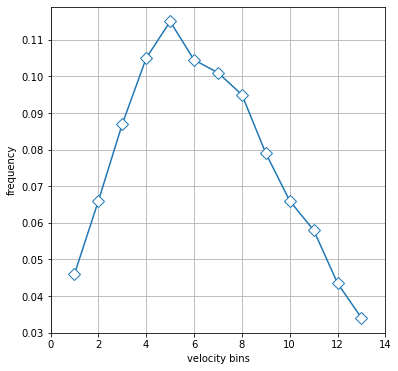

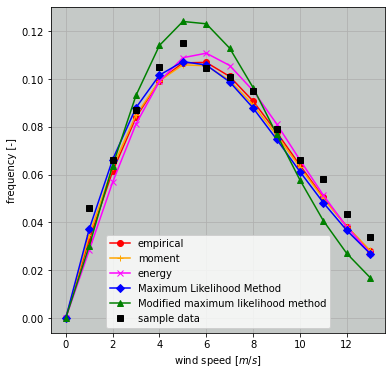

In [23]:
#Functor:
functor = [empirical, moment, energy, mlm, mmlm]
names = ['empirical', 'moment', 'energy', 'mlm', 'mmlm']
print('\n')
k, c = [], []
for i, e in enumerate(functor):
    ki, ci  = e(v, f)
    k.append(ki); c.append(ci)
    print(names[i].capitalize(), ' method yields:')
    print('shape parameter: {0:5.3f}, scale parameter: {1:5.3f}'.format(ki, ci))
    print()
    
#Sample data:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.plot(v, f, marker='D', markersize=8, markerfacecolor='w')
ax.grid()
ax.set_xlim(0,14)
ax.set_xlabel('velocity bins')
ax.set_ylabel('frequency')
plt.show()

#Weibull function:
def weibull(_x, _k, _c):
    p = ((_k/_c)*(_x/_c)**(_k-1))*np.exp(-(_x/_c)**_k)
    return p

#Embedded charts:
weib = plt.figure(figsize=(6,6))
axis = weib.add_subplot(1,1,1)
x = np.arange(14)
colors = ['red', 'orange', 'magenta', 'blue', 'green']
labels = ['empirical','moment','energy','Maximum Likelihood Method','Modified maximum likelihood method']
markers = ['o','+','x','D','^']
for i in range(len(k)):
    axis.plot(x, weibull(x, k[i], c[i]), color=colors[i], label=labels[i], marker=markers[i])
    axis.legend()
    axis.grid()
    axis.set_xlabel(r'wind speed $[m/s]$')
    axis.set_ylabel(r'frequency [-]')
    axis.set_facecolor('xkcd:silver')
axis.plot(v, f, 'b^', color='black', label='sample data', marker='s')
axis.legend()
plt.show()